# Simulate change in porosity due to externally applied pressure

In [1]:
import pybamm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
from scipy.integrate import solve_ivp
from scipy.fft import fft, fftfreq, fftshift
from scipy.signal import savgol_filter
from scipy.signal import find_peaks
from scipy import interpolate
plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 300
plt.style.use('seaborn-white')

eSOH_DIR = "./data/esoh/"
oCV_DIR = "./data/ocv/"
fig_DIR = "./figures/"


In [3]:
def nmc_volume_change_mohtat(sto):
    t_change = -1.10/100*(1-sto)
    return t_change

def graphite_volume_change_mohtat(sto):
    stoichpoints = np.array([0,0.12,0.18,0.24,0.50,1])
    thicknesspoints = np.array([0,2.406/100,3.3568/100,4.3668/100,5.583/100,13.0635/100])
    x = [sto]
    t_change = pybamm.Interpolant(stoichpoints, thicknesspoints, x, name=None, interpolator='linear', extrapolate=True, entries_string=None)
    return t_change

def get_parameter_values():
    parameter_values = pybamm.ParameterValues(chemistry=pybamm.parameter_sets.Mohtat2020)
    parameter_values.update(
        {
            # mechanical properties
            "Positive electrode Poisson's ratio": 0.3,
            "Positive electrode Young's modulus [Pa]": 375e9,
            "Positive electrode reference concentration for free of deformation [mol.m-3]": 0,
            "Positive electrode partial molar volume [m3.mol-1]": -7.28e-7,
            "Positive electrode volume change": nmc_volume_change_mohtat,
            # Loss of active materials (LAM) model
            "Positive electrode LAM constant exponential term": 2,
            "Positive electrode critical stress [Pa]": 375e6,
            # mechanical properties
            "Negative electrode Poisson's ratio": 0.2,
            "Negative electrode Young's modulus [Pa]": 15e9,
            "Negative electrode reference concentration for free of deformation [mol.m-3]": 0,
            "Negative electrode partial molar volume [m3.mol-1]": 3.1e-6,
            "Negative electrode volume change": graphite_volume_change_mohtat,
            # Loss of active materials (LAM) model
            "Negative electrode LAM constant exponential term": 2,
            "Negative electrode critical stress [Pa]": 60e6,
            # Other
            "Cell thermal expansion coefficient [m.K-1]": 1.48E-6,
            "Lower voltage cut-off [V]": 3.0
        },
        check_already_exists=False,
    )
    return parameter_values
parameter_values = get_parameter_values()

In [4]:
parameter_values.search("porosity")

Negative electrode porosity	0.3
Positive electrode porosity	0.3
Separator porosity	0.4


In [5]:
cell = 1

In [6]:
cell_no = f'{cell:02d}'
dfe=pd.read_csv(eSOH_DIR+"aging_param_cell_"+cell_no+".csv")
# Remove first RPT
dfe = dfe.drop(dfe.index[0])
dfe = dfe.reset_index(drop=True)
dfe['N']=dfe['N']-dfe['N'][0]
N =dfe.N.unique()
dfo_0=pd.read_csv(oCV_DIR+"ocv_data_cell_"+cell_no+".csv")
print("Cycle Numbers:")
print(*N, sep = ", ") 

Cycle Numbers:
0, 18, 57, 93, 134, 175, 216, 257, 298, 339


In [7]:
dfo = dfo_0[dfo_0['N']==N[0]]
# dfe_0 = dfe[dfe['N']==N[0]]
C_n_init = dfe['C_n'][0]
C_p_init = dfe['C_p'][0]
y_0_init = dfe['y_0'][0] 
if cell_no=='01':
    c_rate_c = 'C/5'
    c_rate_d = 'C/5'
    dis_set = " until 3V"
    # eps_n_data = 0.6234
    # eps_p_data = 0.4542
elif cell_no=='13':
    c_rate_c = 'C/5'
    c_rate_d = 'C/5'
    dis_set = " for 150 min"

In [8]:
pybamm.set_logging_level("WARNING")
# pybamm.set_logging_level("NOTICE")
experiment = pybamm.Experiment(
    [
        ("Charge at "+c_rate_c+" until 4.2V", )
    ],
    termination="50% capacity",
#     cccv_handling="ode",
)
spm = pybamm.lithium_ion.SPMe(
    {
        "SEI": "ec reaction limited",
        # "loss of active material": ("stress-driven","none"),
        "loss of active material": "stress-driven",
        "stress-induced diffusion": "true",
        # "pressure driven porosity": "true",
        # "lithium plating": "reversible",
    }
)
# spm.print_parameter_info()

In [9]:
param = spm.param
eps_n_data = parameter_values.evaluate(C_n_init*3600/(param.L_n * param.c_n_max * param.F* param.A_cc))
eps_p_data = parameter_values.evaluate(C_p_init*3600/(param.L_p * param.c_p_max * param.F* param.A_cc))
cs_p_init = parameter_values.evaluate(y_0_init* param.c_p_max)

In [11]:
parameter_values = get_parameter_values()
parameter_values.update(
    {
        "SEI kinetic rate constant [m.s-1]": 1.6827e-16,
        "Positive electrode LAM constant proportional term [s-1]": 8.3569e-6,
        "Negative electrode LAM constant proportional term [s-1]": 5.8032e-5,
        "EC diffusivity [m2.s-1]": 2e-18,
        "Positive electrode LAM constant exponential term": 2,
        "Negative electrode LAM constant exponential term": 2,
        "Negative electrode active material volume fraction": eps_n_data,
        "Positive electrode active material volume fraction": eps_p_data,
    },
    check_already_exists=False,
)

In [12]:
sim_exp = pybamm.Simulation(spm, experiment=experiment, parameter_values=parameter_values, 
                            solver=pybamm.CasadiSolver("safe"))
sol_exp = sim_exp.solve(initial_soc=0)

In [13]:
# spm.variable_names()

In [15]:
t = sol_exp["Time [s]"].entries
I = sol_exp["Current [A]"].entries
Q = -sol_exp['Discharge capacity [A.h]'].entries
Vt = sol_exp["Terminal voltage [V]"].entries
exp = 30e6*sol_exp["Cell thickness change [m]"].entries
exp_n = 30e6*sol_exp["Negative Electrode thickness change [m]"].entries
exp_p = 30e6*sol_exp["Positive Electrode thickness change [m]"].entries
ee_p = sol_exp["X-averaged positive electrode porosity"].entries
ee_n = sol_exp["X-averaged negative electrode porosity"].entries
ee_s = sol_exp["X-averaged separator porosity"].entries
j_n = sol_exp["X-averaged negative electrode total interfacial current density [A.m-2]"].entries
j_p = sol_exp["X-averaged positive electrode total interfacial current density [A.m-2]"].entries

In [16]:
j_n_1 = sol_exp["X-averaged negative electrode interfacial current density"].entries
j_n_2 = sol_exp["X-averaged negative electrode interfacial current density [A.m-2]"].entries

In [17]:
print(j_n[0])
print(j_n_1[0])
print(j_n_2[0])

-0.10935297536124446
-0.4548387096774194
-0.10935297536124446


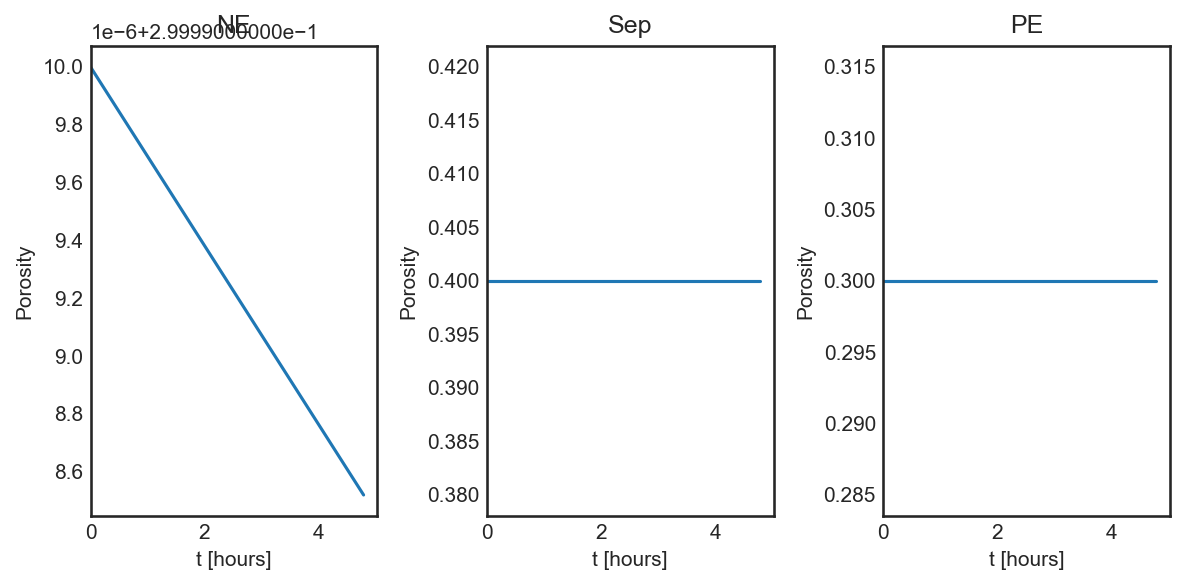

In [18]:
fig = plt.figure(figsize=[8,4])
ax1 = plt.subplot(1,3,1)
ax1.plot(t/3600,ee_n)
ax1.set_xlim(left=0)
ax1.set_xlabel('t [hours]')
ax1.set_ylabel('Porosity')
ax1.set_title('NE')
ax2 = plt.subplot(1,3,2)
ax2.plot(t/3600,ee_s)
ax2.set_xlim(left=0)
ax2.set_xlabel('t [hours]')
ax2.set_ylabel('Porosity')
ax2.set_title('Sep')
ax3 = plt.subplot(1,3,3)
ax3.plot(t/3600,ee_p)
ax3.set_xlim(left=0)
ax3.set_xlabel('t [hours]')
ax3.set_ylabel('Porosity')
ax3.set_title('PE')
fig.tight_layout()

In [19]:
F =  parameter_values.evaluate(param.F)
c_n_max =  parameter_values.evaluate(param.c_n_max)
c_p_max = (param.c_p_max)
R_n = parameter_values.evaluate(param.R_n_typ)
R_p = parameter_values.evaluate(param.R_p_typ)
dfdth = .01 # Assuming 1% strain spring
eps_n_init = 0.3
j_n_val = -0.10935/F

In [20]:
def ode_eps(y, t,R_n,c_n_max,dfdth,j_n_val):
    dydt = 3*(1-y)/R_n/c_n_max*dfdth*j_n_val
    #dydt = -3/R_n/c_n_max*j_n_val*60
    return dydt

In [21]:
from scipy.integrate import odeint

In [22]:
eps_n_sol = odeint(ode_eps, 0.3, t, args=(R_n,c_n_max,dfdth,j_n_val))

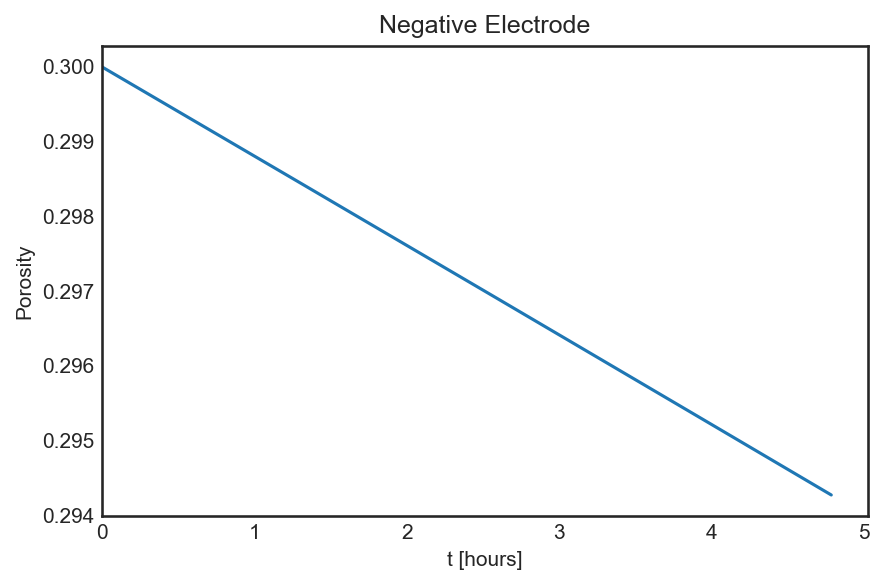

In [24]:
fig = plt.figure(figsize=[6,4])
ax1 = plt.subplot(1,1,1)
ax1.plot(t/3600,eps_n_sol)
ax1.set_xlim(left=0)
ax1.set_xlabel('t [hours]')
ax1.set_ylabel('Porosity')
ax1.set_title('Negative Electrode')
# ax2 = plt.subplot(1,2,2)
# ax2.plot(Q,j_p)
# ax2.set_xlim(left=0)
# ax2.set_xlabel('Q [Ah]')
# ax2.set_ylabel('j [A/m2]')
# ax2.set_title('PE')
fig.tight_layout()
fig.savefig(fig_DIR +'porosity_sim.png')

# Solving the above using PyBaMM solver instead of scipy

In [ ]:
def ode_eps(y, t,R_n,c_n_max,dfdth,j_n_val):
    dydt = 3*(1-y)/R_n/c_n_max*dfdth*j_n_val
    #dydt = -3/R_n/c_n_max*j_n_val*60
    return dydt

In [ ]:
model = pybamm.BaseModel()

In [ ]:
y = pybamm.Variable("y")

In [ ]:
dydt = 3*(1-y)/R_n/c_n_max*dfdth*j_n_val

In [ ]:
model.rhs = {y: dydt}

In [ ]:
model.initial_conditions={y: pybamm.Scalar(0.3)}

In [ ]:
model.variables = { "y": y}

In [ ]:
disc = pybamm.Discretisation()  # use the default discretisation
disc.process_model(model);

In [ ]:
solver = pybamm.ScipySolver()
t_in = np.linspace(0, 17230, 17230)
solution = solver.solve(model, t_in)

In [ ]:
t_sol, y_sol = solution.t, solution.y  # get solution times and states
y = solution["y"]  # extract and process y from the solution

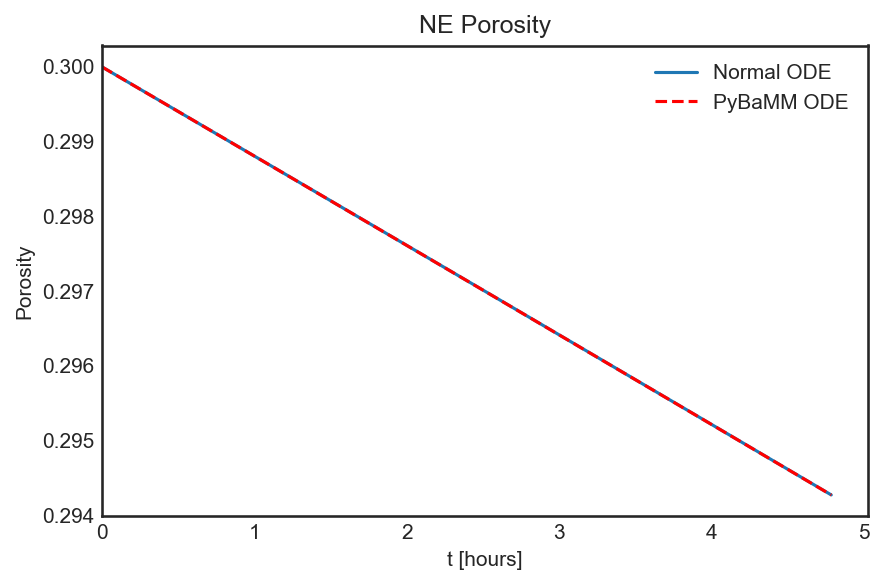

In [ ]:
fig = plt.figure(figsize=[6,4])
ax1 = plt.subplot(1,1,1)
ax1.plot(t/3600,eps_n_sol)
ax1.plot(t_sol/3600,y(t_sol),'r--')
ax1.set_xlim(left=0)
ax1.set_xlabel('t [hours]')
ax1.set_ylabel('Porosity')
ax1.set_title('NE Porosity')
# ax2 = plt.subplot(1,2,2)
# ax2.plot(Q,j_p)
# ax2.set_xlim(left=0)
# ax2.set_xlabel('Q [Ah]')
# ax2.set_ylabel('j [A/m2]')
# ax2.set_title('PE')
ax1.legend(['Normal ODE','PyBaMM ODE'])
fig.tight_layout()

# Other Plots

In [ ]:
# fig = plt.figure(figsize=[6,4])
# ax1 = plt.subplot(1,2,1)
# ax1.plot(Q,j_n)
# ax1.set_xlim(left=0)
# ax1.set_xlabel('Q [Ah]')
# ax1.set_ylabel('j [A/m2]')
# ax1.set_title('NE')
# ax2 = plt.subplot(1,2,2)
# ax2.plot(Q,j_p)
# ax2.set_xlim(left=0)
# ax2.set_xlabel('Q [Ah]')
# ax2.set_ylabel('j [A/m2]')
# ax2.set_title('PE')
# fig.tight_layout()

In [ ]:
# fig = plt.figure(figsize=[8,4])
# ax1 = plt.subplot(1,3,1)
# ax1.plot(Q,exp_n)
# ax1.set_xlim(left=0)
# ax1.set_xlabel('Q [Ah]')
# ax1.set_ylabel('Exp [$\mu$m]')
# ax1.set_title('NE')
# ax2 = plt.subplot(1,3,2)
# ax2.plot(Q,exp)
# ax2.set_xlim(left=0)
# ax2.set_xlabel('Q [Ah]')
# ax2.set_title('Total')
# ax2.set_ylabel('Exp [$\mu$m]')
# ax3 = plt.subplot(1,3,3)
# ax3.plot(Q,exp_p)
# ax3.set_xlim(left=0)
# ax3.set_xlabel('Q [Ah]')
# ax3.set_ylabel('Exp [$\mu$m]')
# ax3.set_title('PE')
# fig.tight_layout()